<a href="https://colab.research.google.com/github/PiotrMaciejKowalski/kurs-analiza-danych-2022/blob/main/Tydzie%C5%84%203/Elementy_klasyfikacji.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Elementy klasyfikacji

Ten dokument omawia zagadnienia *analizy dyskryminacyjnej* i powiązany z nim problem *klasyfikacji*.  

Najogólniej analiza dyskryminacyjna zajmuje się modelowaniem zależności zmiennej losowej $Y$ od zmiennej $X$ dla wektora $(X, Y)$, gdzie $Y$ jest zmienną jakościową (na skali nominalnej) a $X$ &mdash; (być może wielowymiarową) zmienną losową w zasadzie dowolnego typu (choć niektóre metody mają pewne ograniczenia). 

Celem analizy dyskryminacyjnej jest modelowanie prawdopodobieństwa warunkowego $$P( Y = y | X = x),$$ w oparciu o próbę statystyczną $(X_1, Y_1), \dots, (X_n, Y_n)$.

Najbardziej naturalnym pytaniem jest dla jakiej wartości $y \in Y(\Omega)$ jest ono największe, co prowadzi do zdefiniowania funkcji *klasyfikatora*:

$$f(x) = \arg \max_y P( Y = y | X = x).$$ 

Z grubsza więc analiza dyskryminacyjna jest odpowiednikiem *analizy regresji*, a klasyfikacja &mdash; *prognozowania statystycznego*, różnica wynika tylko z typu (skali pomiarowej) zmiennej objaśnianej. 


Przegląd metod analizy dyskryminacyjnej w Pythonie rozpocznijmy od wczytania standardowych pakietów oraz przykładowego zbioru danych (klasycznego zbioru *iris*).

In [ ]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd

In [ ]:
from sklearn import datasets

dataset = datasets.load_iris()


## Preprocessing 

Dokonajmy konwersji zbioru danych na pakiety *numpy* i *pandas*.

   sepal length (cm)  sepal width (cm)  ...  petal width (cm)  target
0                5.1               3.5  ...               0.2     0.0
1                4.9               3.0  ...               0.2     0.0
2                4.7               3.2  ...               0.2     0.0
3                4.6               3.1  ...               0.2     0.0
4                5.0               3.6  ...               0.2     0.0

[5 rows x 5 columns]


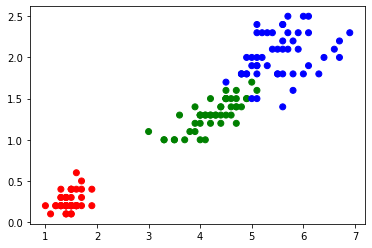

In [ ]:
%matplotlib inline 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


size = len(dataset.data)

data = np.concatenate([dataset.data, np.reshape(dataset.target, (size,1))], axis = 1)
column_names = dataset.feature_names[:]
column_names.append('target')
df = pd.DataFrame(data, columns = column_names, copy = True)
print(df.head())

plt.scatter(df['petal length (cm)'], df['petal width (cm)'], c = df['target'].replace({0: 'r', 1: 'g', 2: 'b'}))
plt.show()


# Regresja logistyczna

Regresja logistyczna jest dość prostą techniką, która wywodzi się z metod regresji, a daje się użyć, gdy zmienna objaśniana jest na skali dychotomicznej (tzn. gdy możemy przyjąć, że $Y(\Omega) = \{0, 1\}$). Zauważmy, że wprost nie da się technik regresji zastosować, ale zauważając, że $\mathbb{E}Y = \mathbb{P}(Y = 1)$ możemy modelować $p(x) = \mathbb{E}(Y | X = x) \in (0, 1)$.

Aby móc zastosować liniową funkcję zmiennej $x$ dokonuje się przekształcenia przedziału $(0, 1)$ na cały zbiór $\mathbb{R}$ przez odwzorowanie $\operatorname{logit}(p(x)) = \ln \frac{p(x)}{1-p(x)}$, a następnie modeluje się $\operatorname{logit}(p(x)) \approx ax + b$.

Warto pamietać, że prawdziwe są zależności $$p(x) = \frac{1}{1+e^{-\operatorname{logit}(p(x))}}, \qquad 1 - p(x) = \frac{1}{1+e^{\operatorname{logit}(p(x))}}.$$

## Estymacja parametrów regresji

Estymacji parametrów regresji logistycznej dokonuje się *metodą największej wiarygodności* (MLE), gdzie funkcja wiarygodności jest postaci
$$L(X, Y, a, b) = \left\{
\begin{array}{cc}
\hat{p}(X) & \textrm{ gdy } Y = 1 \\
1 - \hat{p}(X) & \textrm{ gdy } Y = 0
\end{array} \right., \textrm{gdzie } \hat{p}(X) = \frac{1}{1+e^{-aX-b}}.$$
Zatem
$L(X, Y, a, b) = \hat{p}(X)^Y + (1-\hat{p}(X))^{1-Y}.$
Dla próby statystycznej funkcja wiarygodności jest postaci
$$L((X_1, Y_1), \dots (X_n, Y_n), a, b) = \prod_{i=1}^n L(X_i, Y_i, a, b).$$
Wyznaczając maksymum powyższej funkcji względem $a, b$ wygodniej jest ją uprzednio zlogarytmizować (logarytm jest funkcją rosnącą, więc nie wpływa to na wielkość argumentów) stąd wyznacza się
$$\max_{a, b} \sum_{i=1}^n \ln L(X_i, Y_i, a, b) = \max_{a,b} \sum_{i=1}^n Y_i(aX_i + b) -\ln(1+e^{aX_i+b}).
$$
Parametry $a, b$ wyznacza się numerycznie, przy czym istnieją ku temu dedykowane metody (iteracyjne, metodą kolejnych przybliżeń). 

## Obliczenia na przykładowych danych

Ponieważ zmienna objaśniana powinna przyjmować tylko dwie wartości dokonamy rozpoznania wyłącznie jednego z dwóch gatunków kwiatów, rezygnując z tego, który jest łatwo klasyfikowalny. Z uwagi na prostotę i dobre narzędzia oceny modelu zrezygnujemy na tym etapie z wyodrębniania części uczącej i testowej ze zbioru danych.

In [ ]:
df2 = df[df['target'] > 0].copy()
X = df2[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']]
y = df2['target'] == 2

### Pakiet *statsmodels*

Rozpoczniemy od użycia wszystkich zmiennych, jako objaśniających.

In [ ]:
import statsmodels.api as sm

Xww = sm.add_constant(X)
log_reg = sm.Logit(y, Xww).fit()
print(log_reg.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Optimization terminated successfully.
         Current function value: 0.059493
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                  100
Model:                          Logit   Df Residuals:                       95
Method:                           MLE   Df Model:                            4
Date:                Wed, 05 May 2021   Pseudo R-squ.:                  0.9142
Time:                        15:37:50   Log-Likelihood:                -5.9493
converged:                       True   LL-Null:                       -69.315
Covariance Type:            nonrobust   LLR p-value:                 1.947e-26
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -42.6378     25.708     -1.659      0.097     -93.024       7.748
sepal l

Wstępna analiza sugeruje, że najmniej istotną zmienną objaśniającą jest długość działki kielicha, następnie jej szerokość, a dalej szerokość płatka, zaś najbardziej istotna jest zależność od długości płatka. Spójrzmy więc na modele przy kolejnej eliminacji zmiennych objaśniających. Narzędziem do porównania może być bayesowskie kryterium informacyjne Schwarza.
$$ \operatorname{BIC} = k \ln n - 2 \ln \hat{L}, $$
gdzie $k$ jest liczbą parametrów modelu, $n$ &mdash; licznością zbioru danych, a $\hat{L}$ &mdash; optymalną wartością funkcji wiarygodności.

In [ ]:
lista = [0,2,3,4]
print(Xww.head())  # wyraz wolny na początku
Xww2 = Xww.iloc[:, lista]
log_reg2 = sm.Logit(y, Xww2).fit()
print(log_reg2.summary())
print(log_reg.bic)
print(log_reg2.bic) # lepszy model!

    const  sepal length (cm)  ...  petal length (cm)  petal width (cm)
50    1.0                7.0  ...                4.7               1.4
51    1.0                6.4  ...                4.5               1.5
52    1.0                6.9  ...                4.9               1.5
53    1.0                5.5  ...                4.0               1.3
54    1.0                6.5  ...                4.6               1.5

[5 rows x 5 columns]
Optimization terminated successfully.
         Current function value: 0.066329
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                  100
Model:                          Logit   Df Residuals:                       96
Method:                           MLE   Df Model:                            3
Date:                Wed, 05 May 2021   Pseudo R-squ.:                  0.9043
Time:                        15:37:50   Log-Likelihood

In [ ]:
lista = [0,3,4]
Xww3 = Xww.iloc[:, lista]
log_reg3 = sm.Logit(y, Xww3).fit()
print(log_reg3.summary())
print(log_reg3.bic)
print(log_reg2.bic) # lepszy model!

Optimization terminated successfully.
         Current function value: 0.102818
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                  100
Model:                          Logit   Df Residuals:                       97
Method:                           MLE   Df Model:                            2
Date:                Wed, 05 May 2021   Pseudo R-squ.:                  0.8517
Time:                        15:37:50   Log-Likelihood:                -10.282
converged:                       True   LL-Null:                       -69.315
Covariance Type:            nonrobust   LLR p-value:                 2.303e-26
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -45.2723     13.612     -3.326      0.001     -71.951     -18.594
petal l

Ten model i kolejny będa już nieco gorsze. Dla porządku pokażemy jednak zależność wyłącznie od szerokości płatka (okazuje się być najsliniejsza dla jednej zmiennej).

In [ ]:
lista = [0,4]
Xww4 = Xww.iloc[:, lista]
log_reg4 = sm.Logit(y, Xww4).fit()
print(log_reg4.summary())
print(log_reg4.bic)
print(log_reg2.bic) # lepszy model!

Optimization terminated successfully.
         Current function value: 0.167104
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                  100
Model:                          Logit   Df Residuals:                       98
Method:                           MLE   Df Model:                            1
Date:                Wed, 05 May 2021   Pseudo R-squ.:                  0.7589
Time:                        15:37:50   Log-Likelihood:                -16.710
converged:                       True   LL-Null:                       -69.315
Covariance Type:            nonrobust   LLR p-value:                 1.099e-24
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              -21.1256      4.597     -4.596      0.000     -30.135     -12.116
petal width

Wykorzystamy teraz predykcję i naszkicujemy wykres linii regresji logistycznej.

const              -21.125590
petal width (cm)    12.947477
dtype: float64
50     0.047466
51     0.153895
52     0.153895
53     0.013468
54     0.153895
         ...   
145    0.999826
146    0.969957
147    0.991586
148    0.999826
149    0.898427
Length: 100, dtype: float64


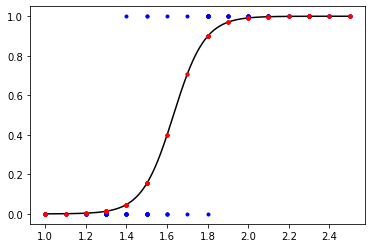

In [ ]:
print(log_reg4.params)
a = log_reg4.params[1]
b = log_reg4.params[0]

def f_logit(x):
  return 1/(1+np.exp(-a*x-b))

plt.plot(X['petal width (cm)'], y, 'b.')
xx = np.linspace(1, 2.5, 500)
yy = f_logit(xx)
plt.plot(xx, yy, "k-")

xx = X['petal width (cm)']
yy = log_reg4.predict(Xww4)
print(yy)
plt.plot(xx, yy, "r.")

plt.show()


Widać niewielką liczbę różnych wartości oraz całkiem sensowną jakość prognozowania.

Podobne działanie ma funkcja *logistic_regression* z pakietu *pingouin*.

## Pakiet *scikit-learn*

Zwyczajowo otrzymujemy funkcje uboższe w część statystyczną i nieco niestandardowe. Za to dość sprawnie działające i obudowane w schemat uczenia maszynowego.

In [ ]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
classifier.fit(X, y)
# prognozowanie na 2 sposoby
y_pred = classifier.predict(X)
print(y_pred)
print(classifier.predict_proba(X)[:,1])
print(classifier.coef_)
print(classifier.intercept_)

#dla porównania
print(log_reg.params)

[False False False False False False False False False False False False
 False False False False False False False False  True False False False
 False False False  True False False False False False  True False False
 False False False False False False False False False False False False
 False False  True  True  True  True  True  True False  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]
[0.157639   0.14384834 0.31923787 0.05139067 0.21002944 0.14360238
 0.2753357  0.00404248 0.13022999 0.04504984 0.00853649 0.08603458
 0.02217117 0.23741004 0.01171332 0.08428743 0.20334967 0.02481411
 0.23298515 0.02116278 0.50446634 0.03202051 0.44703558 0.16811956
 0.0630167  0.09156289 0.24999638 0.53728579 0.18664878 0.00477823
 0.017354   0.01023955 0.02244565 0.65268768 0.21642842

Zaskoczeniem może być, że uzyskaliśmy inne parametry. Wyjaśnieniem tego faktu jest, że regresja logistyczna w pakiecie *scikit-learn* jest domyślnie regularyzowana (grzbietowo). Drobne różnice poniżej wskazują na inne algorytmy numeryczne.

In [ ]:
classifier2 = LogisticRegression(penalty='none')
classifier2.fit(X, y)
print(classifier2.coef_)
print(classifier2.intercept_)
print(log_reg.params)

[[-2.46527253 -6.68063546  9.42921397 18.28585174]]
[-42.63686373]
const               -42.637804
sepal length (cm)    -2.465220
sepal width (cm)     -6.680887
petal length (cm)     9.429385
petal width (cm)     18.286137
dtype: float64


Pozostaje nam sprawdzić skuteczność działania tego klasyfikatora

## Miara accuracy

Podstawowym (i przez to pierwszym) miernikiem jakość klasyfikatora jest 
jego dokładność mierzona za pomocą *accuracy*. Pomimo tego, że jest to 
miara posiadająca pewne obciążenia, nie wyobrażamy sobie nie sprawdzic 
jej wartości. 


In [ ]:

from sklearn.metrics import accuracy_score
print(accuracy_score(y, y_pred))
print(accuracy_score(y, classifier2.predict(X))) #dla porównania bez regularyzacji


0.96
0.98



## Miara macierz pomyłek

Jeśli wynik *accuracy* jest z jakiś powodów niedostateczny &mdash; albo chcemy zrozumieć w szerszym spektrum czego 
brakuje aby osiągnąć doskonałość w klasyfikacji &mdash; sięgamy po macierz pomyłek

In [ ]:
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(y, y_pred))

,0,1
0,47,3
1,1,49



## Test walidacji krzyżowej

Sprawdźmy czy dokładność klasyfikatora jest wolna od pewnych perturbacji zbioru treningowego


In [ ]:

from sklearn.model_selection import cross_val_score
print(pd.DataFrame(cross_val_score(classifier, X, y, cv=5, scoring = 'accuracy')))
print(pd.DataFrame(cross_val_score(classifier2, X, y, cv=5, scoring = 'accuracy')))

      0
0  0.95
1  1.00
2  0.90
3  0.95
4  1.00
     0
0  1.0
1  1.0
2  0.9
3  0.9
4  1.0


## Zależność wyłącznie od *petal.width*

Poniżej widać, że regularyzacja istotnie psuje jakość prostej regresji logistycznej (warto porównać z analogicznym wykresem narysowanym wyżej). 

[False False False False False False False False False False False False
 False False False False False False False False  True False False False
 False False False  True False False False False False False False False
 False False False False False False False False False False False False
 False False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True False  True  True
  True  True  True  True  True  True  True False  True  True  True False
 False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]
0.94


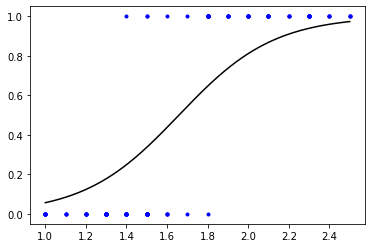

    0   1
0  48   2
1   4  46


In [ ]:
classifier3 = LogisticRegression() 

classifier3.fit(X.iloc[:,[3]], y)
y_pred3 = classifier3.predict(X.iloc[:,[3]])
print(y_pred3)
print(accuracy_score(y, y_pred3))
a = classifier3.coef_[0][0]
b = classifier3.intercept_[0]

def f_logit(x):
  return 1/(1+np.exp(-a*x-b))

plt.plot(X['petal width (cm)'], y, 'b.')
xx = np.linspace(1, 2.5, 500)
yy = f_logit(xx)
plt.plot(xx, yy, "k-")
plt.show()

#print(pd.DataFrame(confusion_matrix(y_test, y_pred)))
print(pd.DataFrame(confusion_matrix(y, y_pred3)))



## Precyzja, czułość i specyficzność

Kolejne trzy miary dostępne do klasyfikacji to *precyzja*, *czułość* i *specyficzność*. Do ich rachunku wykrozystuje się
podział wszystkich wyników klasyfikacji na 4 grupy 

* tp &mdash; true - positive &mdash; gdy klasyfikator otrzymał obiekt z cechą i poprawnie ją wykrył,
* fp &mdash; false - positive &mdash; gdy klasyfikator otrzymał obiekt bez cechy ale niepoprawnie ją zgłosił,
* tn &mdash; true -negative &mdash; gdy klasyfikator otrzymał obiekt bez cechy i poprwawnie wykrył jej brak,
* fn &mdash; false - negative &mdash; gdy klasyfikator otrzymał obiekt z cechą ale niepoprawnie jej niezgłosił.

Precyzja oznacza liczbę poprawnych rozpoznań spośród wszystkich sytuacji gdy cecha została wykryta, tj.

$$P = \frac{tp}{tp+fp}.$$

Z kolei czułość mówi nam o tym jak często klasyfikator reaguje zgłaszając ceche 
(jaką część pozytywnych przypadków rozpoznaje w swojej klasyfikacji). Tzn.
$$R = \frac{tp}{tp+fn}.$$ 

Te dwie miary daje się wspólnie podsumować za pomocą średniej harmonicznej - nazywana miarę $F_1$.

$$F_1 = 2 \frac{P \cdot R}{P+R}.$$ 

Kolejną, istotną miarą jest specyficzność klasyfikatora (zdolność rozpoznawania przypadków negatywnych).

$$S = \frac{tn}{tn+fp}.$$

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
print(f'Wartość precyzji   {precision_score(y, y_pred)}')
print(f'Wartość czułości   {recall_score(y, y_pred)}')
print(f'Wartość f1         {f1_score(y, y_pred)}')
cm = confusion_matrix(y, y_pred)
print(cm)
print(f'Wartość specyficzności   {cm[0][0]/(cm[0][0]+cm[0][1])}')

Wartość precyzji   0.9423076923076923
Wartość czułości   0.98
Wartość f1         0.9607843137254902
[[47  3]
 [ 1 49]]
Wartość specyficzności   0.94


### Krzywa *ROC*

Wybierając inny poziom (prawdopodobieństwo) odcięcia można uzyskać za pomoca regresji logistycznej całą rodzinę klasyfikatorów. Zmiana tego poziomu wpływa na kształt macierzy pomyłek, a zatem i na czułość oraz specyficzność. Stąd sens ma poniższy wykres przedstawiający zależność między czułością a specyficznością.

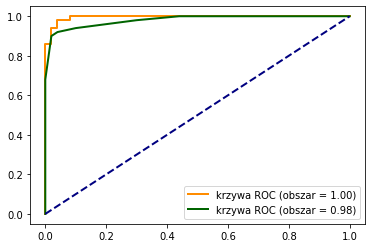

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

plt.figure()
p1 = classifier.predict_proba(X)[:,1]
fpr, tpr, _ = roc_curve(y, p1)
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='krzywa ROC (obszar = %0.2f)' % roc_auc_score(y, p1))

p3 = classifier3.predict_proba(X.iloc[:,[3]])[:,1]
fpr, tpr, _ = roc_curve(y, p3)
plt.plot(fpr, tpr, color='darkgreen',
         lw=2, label='krzywa ROC (obszar = %0.2f)' % roc_auc_score(y, p3))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc="lower right")
plt.show()

Alternatywna metoda (choć nie rozumeim sensu wygładzenia wykresu na obu rysunkach w drugim przypadku).

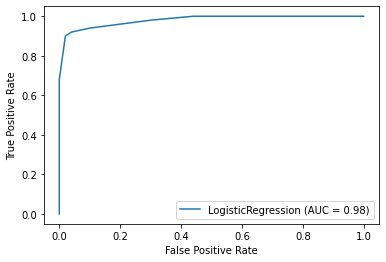

In [ ]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(classifier3, X.iloc[:,[3]], y)
plt.show()

# Klasyfikacja metodą nabliższych sąsiadów

In [ ]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd


# Algorytm kNN

W niniejszej lekcji zaprezentujemy użycie wbudowanych bibliotek do pracy z algorytmem kNN. Rozpoczniemy od użycia klasyfikatora kNN. Jest on bardzo prosty i bardzo skuteczny. Ma jednak wady:

* skłonność do przeuczania
* jest wyłącznie algorytmem klasyfikacji (nie ma łatwego odpowiednika w ramach analizy dyskryminacyjnej)
* brak wpływu na poziom (prawdopodobieństwo) odcięcia &mdash; trudno inaczej szacować prawdopodobieństwo przypisania do określonej grupy niż przez jej liczność w zbiorze uczącym 

# Klasyfikcja algorytmem kNN 

Standardowo musimy rozpocząć od wybrania zbioru danych na którym będziemy pracować. W naszym przypadku będzie to 
ponownie zbiór Iris. Rozcznijmy od jego wczytania


In [ ]:
from sklearn import datasets

dataset = datasets.load_iris()


## Preprocessing 

Dokonajmy ich konwersji na nasze ulubione pakiety numpy i pandas

In [ ]:
import numpy as np
import pandas as pd

size = len(dataset.data)

data = np.concatenate([dataset.data, np.reshape(dataset.target, (size,1))], axis = 1)
column_names = dataset.feature_names[:]
column_names.append('target')
df = pd.DataFrame(data, columns = column_names, copy = True)
df.head()


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0



Dokonajmy podziału na zmienne objaśniane i objaśniające


In [ ]:
X = df[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']]
y = df['target']



Przeprowadźmy prosty podział naszego zbioru na testowy i treningowy


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test , y_train, y_test = train_test_split(X, y)



## Proste użycie klasyfikatora kNN

Zaprezentujemy teraz użycie implementacji bibliotecznej klasyfikata kNN. 
Dokumentacja do modułu znajduje sie na [https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html]()


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier(n_neighbors = 5)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

Pozostaje nam sprawdzić skuteczność działania tego klasyfikatorów

## Miara accuracy

Podstawowym (i przez to pierwszym) miernikiem jakość klasyfikatora jest 
jego dokładność mierzona za pomocą accuracy. Pomimo tego, że jest to 
miara posiadająca pewne obciążenia, nie wyobrażamy sobie nie sprawdzic 
jej wartości. 


In [ ]:

from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)


0.9473684210526315


## Miara macierz pomyłek

Jeśli wynik accuracy jest z jakiś powodów niedostateczny - albo chcemy zrozumieć w szerszym spektrum czego 
brakuje aby osiągnąć doskonałość w klasyfikacji - sięgamy po macierz omyłek

In [ ]:
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(y_test, y_pred))

,0,1,2
0,15,0,0
1,0,14,2
2,0,0,7



## Test walidacji krzyżowej

Sprawdźmy czy dokładność naszego klasyfikatora jest wolna od pewnych perturbacji zbioru treningowego


In [ ]:

from sklearn.model_selection import cross_val_score
pd.DataFrame(cross_val_score(classifier, X_train, y_train, cv=5, scoring = 'accuracy'))

,0
0,0.956522
1,1.000000
2,1.000000
3,1.000000
4,0.954545



## Precyzja i czułość

Kolejne dwie miary dostępne do klasyfikacji to *precyzja*, *czułość* analogiczne dla miar przy podziale na dwie grupy. Przy ich większej liczbie najpierw są liczone dla każdej grupy osobno (dana grupa vs reszta), a następnie uśredniane metodą określoną parametrem *average*.



In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
print(f'Wartość precyzji   {precision_score(y_test, y_pred, average="macro")}')
print(f'Wartość czułości {recall_score(y_test, y_pred, average="macro")}')
print(f'Wartość f1         {f1_score(y_test, y_pred, average="macro")}')


Wartość precyzji   0.9259259259259259
Wartość czułości 0.9583333333333334
Wartość f1         0.9361111111111112


# Przekazanie własnej funkcji odległości do klasyfikatora

Z uwagi na charakter modelu kNN może dla niego być bardzo istotne abyśmy umieli zmodyfikować określoną w nim metrykę lub wagi.

Zgodnie z dokumentacją na stronie scikit mamy kilka możliwości:

    weightsstr or callable, optional (default = ‘uniform’)

    weight function used in prediction. Possible values:

        ‘uniform’ : uniform weights. All points in each neighborhood are weighted equally.

        ‘distance’ : weight points by the inverse of their distance. in this case, 
                    closer neighbors of a query point will have a greater influence 
                    than neighbors which are further away.

        [callable] : a user-defined function which accepts an array of distances, 
                    and returns an array of the same shape containing the weights.*

Przez callable rozumieć należy funkcje oraz klasy których obiekty można wywoływać jak funkcje. Oznacza to, że możemy w szczególności
podać swój sposób na ważenie np. za pomocą wyrażenia lambda (więcej w materiałach wprowadzenie do pythona).

Zgodnie z opisem tej funkcji ma ona otrzymać odległości pomiędzy danymi wyrażonymi metryką i zwrócić wektor wag


In [ ]:

def compute_weights(distances: np.ndarray):
    avg = np.mean(distances)
    sum_avg = np.sum(distances[distances <= avg])
    weights = np.zeros(distances.shape)
    weights[distances <= avg] = distances[distances <= avg] / sum_avg
    return weights

classifier = KNeighborsClassifier(n_neighbors = 5, weights = compute_weights)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

 
Sprawdźmy jak to działa


In [ ]:

from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)


0.868421052631579


Gorzej, ale co ważne - zdecydowanie inaczej.

Aby tym razem zadać własną miarę - odnajdujemy w dokumentacji:

    metricstring or callable, default ‘minkowski’    
        the distance metric to use for the tree. The default metric is minkowski, and 
        with p=2 is equivalent to the standard Euclidean metric. See the documentation of the 
        DistanceMetric class for a list of available metrics. If metric is “precomputed”, 
        X is assumed to be a distance matrix and must be square during fit. X may be a Glossary, 
        in which case only “nonzero” elements may be considered neighbors.
        
Spróbujmy zatem utworzyć miarę obliczają odległość jedynie na podstawie pierwszej zmiennej


In [ ]:
import math
classifier = KNeighborsClassifier(n_neighbors = 5, metric=lambda x, y: math.sqrt( (x[0] - y[0])**2))
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

 
Sprawdźmy jak to zadziała


In [ ]:

from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)


0.6842105263157895


Skąd od razu widzimy, że był to zły wybór. 

Pozostawiliśmy sobie jednak wykonanie odrobinę prostszej rzeczy. Co jeśli nie interesuje nas ogólnie inna metryka, ale 
zwykłe przejście z Euklidesowej metryki na Manhattan. Obie są metrykami Minkowskiego co jest domyślnym parametrem. 
Okazuje się że wystarczy zmanipulować dodatkowy parametr


In [ ]:
import math
classifier = KNeighborsClassifier(n_neighbors = 5, p = 1)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

 
Sprawdźmy jak to zadziała


In [ ]:

from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)


0.9736842105263158


# Klasyfikacja RNN 

Dostępna jest jeszcze inna wersja klasyfikatora, w której do oceny grupy brane są jedynie te znajdują się dostatecznie
blisko w sensie metryki. Oznacza to zmianę działania z określonej liczby sąsiadów na określony rozmiar sąsiedztwa

Dokumentacja do modułu znajduje sie na [https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.RadiusNeighborsClassifier.html#sklearn.neighbors.RadiusNeighborsClassifier]()


In [ ]:
from sklearn.neighbors import RadiusNeighborsClassifier

classifier = RadiusNeighborsClassifier(radius=1)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)


Pozostaje nam sprawdzić skuteczność działania tego klasyfikatora.

## Miara accuracy

Podstawowym (i przez to pierwszym) miernikiem jakość klasyfikatora jest 
jego dokładność mierzona za pomocą accuracy. Pomimo tego, że jest to 
miara posiadająca pewne obciążenia, nie wyobrażamy sobie nie sprawdzic 
jej wartości. 


In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)


0.9473684210526315


## Miara macierz pomyłek

Jeśli wynik accuracy jest z jakiś powodów niedostateczny - albo chcemy zrozumieć w szerszym spektrum czego 
brakuje aby osiągnąć doskonałość w klasyfikacji - sięgamy po macierz omyłek

In [ ]:
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(y_test, y_pred))

,0,1,2
0,15,0,0
1,0,14,2
2,0,0,7



## Test walidacji krzyżowej

Sprawdźmy czy dokładność naszego klasyfikatora jest wolna od pewnych perturbacji zbioru treningowego


In [ ]:
from sklearn.model_selection import cross_val_score
pd.DataFrame(cross_val_score(classifier, X_train, y_train, cv=5, scoring = 'accuracy'))

,0
0,0.956522
1,1.000000
2,1.000000
3,1.000000
4,0.954545


## Precyzja i czułość

Kolejne dwie miary dostępne do klasyfikacji to *precyzja*, *czułość* analogiczne dla miar przy podziale na dwie grupy. Przy ich większej liczbie najpierw są liczone dla każdej grupy osobno (dana grupa vs reszta), a następnie uśredniane metodą określoną parametrem *average*.


In [ ]:

from sklearn.metrics import precision_score, recall_score, f1_score
print(f'Wartość precyzji   {precision_score(y_test, y_pred, average="macro")}')
print(f'Wartość czułości {recall_score(y_test, y_pred, average="macro")}')
print(f'Wartość f1         {f1_score(y_test, y_pred, average="macro")}')


Wartość precyzji   0.9259259259259259
Wartość czułości 0.9583333333333334
Wartość f1         0.9361111111111112


# Klasyfikacja w ujęciu bayesowskim

Na ogół $\mathbb{P} (Y = y | X = x)$ liczy się trudno (zwłaszcza dla wielowymiarowych zmiennych $X$. Korzystamy więc z reguły Bayesa
$$ \mathbb{P}(Y = y | X = x) = \frac{\mathbb{P}(Y = y \cap X = x)}{\mathbb{P}(X = x)} = \frac{\mathbb{P}(Y = y) \mathbb{P}(X = x | Y = y)}{\mathbb{P}(X = x)}$$
Klasyfikator bayesowski ma więc postać:
$$f(x) = \arg \max_{y \in Y(\Omega)} \mathbb{P}(Y = y) \mathbb{P}(X = x | Y = y).$$
Oba (a w zasadzie wszystkie 3) składowe: tzn. *p-stwo a'priori*, rozkład $X$ w grupach (warunkowy), i rozkład $X$ (łączny) liczy się nieco łatwiej, choć poznanie rozkładu zmiennej $X$ w grupach nadal jest problemem nietrywialnym. Stosowane podejścia to:

* przyjęcie, że $X$ ma (wielowymiarowy) rozkład normalny o identycznej dla każdej grupy macierzy kowariancji &mdash; prowadzi do *liniowej analizy dyskryminacyjnej*
* przyjęcie, że $X$ ma (wielowymiarowy) rozkład normalny o różnych w ramach grup macierzach kowariancji &mdash; prowadzi do *kwadratowej analizy dyskryminacyjnej*
* przyjęcie (być może *naiwne*), że współrzędne $X$ w grupach są od siebie niezależne &mdash; daje *naiwny klasyfikator bayesowski*.

## *LDA* i *QDA*

Znowu można zrezygnować z części testowej.

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
classifier4 = LinearDiscriminantAnalysis()
classifier4.fit(X, y)
y_pred = classifier4.predict(X)
print(classifier4.predict_proba(X))
print(classifier4.score(X, y))

[[1.00000000e+00 3.89635793e-22 2.61116827e-42]
 [1.00000000e+00 7.21796992e-18 5.04214335e-37]
 [1.00000000e+00 1.46384895e-19 4.67593159e-39]
 [1.00000000e+00 1.26853638e-16 3.56661049e-35]
 [1.00000000e+00 1.63738745e-22 1.08260527e-42]
 [1.00000000e+00 3.88328166e-21 4.56654013e-40]
 [1.00000000e+00 1.11346945e-18 2.30260848e-37]
 [1.00000000e+00 3.87758638e-20 1.07449600e-39]
 [1.00000000e+00 1.90281306e-15 9.48293562e-34]
 [1.00000000e+00 1.11180261e-18 2.72405964e-38]
 [1.00000000e+00 1.18527749e-23 3.23708368e-44]
 [1.00000000e+00 1.62164851e-18 1.83320074e-37]
 [1.00000000e+00 1.45922505e-18 3.26250644e-38]
 [1.00000000e+00 1.11721886e-19 1.31664193e-39]
 [1.00000000e+00 5.48739873e-30 1.53126473e-52]
 [1.00000000e+00 1.26150510e-27 2.26870463e-48]
 [1.00000000e+00 6.75433806e-25 3.86827125e-45]
 [1.00000000e+00 4.22374070e-21 1.22431307e-40]
 [1.00000000e+00 1.77491130e-22 2.55215324e-42]
 [1.00000000e+00 2.59323738e-22 5.79207874e-42]
 [1.00000000e+00 1.27463866e-19 4.357774

In [ ]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
classifier5 = QuadraticDiscriminantAnalysis()
classifier5.fit(X, y)
y_pred = classifier5.predict(X)
#print(classifier5.predict_proba(X))
print(classifier5.score(X, y))

0.98


### Zadanie 
* szczegółowa ocena klasyfikacji dla LDA lub QDA
* LDA lub QDA porównane z kNN &mdash; zbiór uczący i testowy
* klasyfikatory w oparciu o rozmiary płatka (LDA, QDA, kNN) + wykres sklasyfikowanych danych